# Equidad en Aprendizaje Automático - Trabajo Práctico Final

## Introducción

Este trabajo práctico tiene como objetivo aplicar técnicas de machine learning con un enfoque en equidad y justicia algorítmica. Utilizaremos el conjunto de datos "German Credit Data" para desarrollar modelos de clasificación que predigan la aprobación de préstamos bancarios.

El análisis se estructura en las siguientes etapas:

1. **Exploración del conjunto de datos**: Comprenderemos el origen, composición y características del dataset, identificando posibles sesgos desde el análisis exploratorio.

2. **Desarrollo de un modelo baseline**: Entrenaremos un modelo de regresión logística inicial y evaluaremos su desempeño mediante métricas estándar de clasificación.

3. **Evaluación de equidad**: Analizaremos si el modelo presenta sesgos de género utilizando diferentes criterios de fairness (Statistical Parity, Equalized Odds, Equal Opportunity y Predictive Parity).

4. **Mitigación de sesgos**: Implementaremos técnicas de mitigación para reducir las disparidades identificadas y compararemos los resultados con el modelo inicial.

5. **Conclusiones**: Reflexionaremos sobre el balance entre performance y equidad, y las implicaciones prácticas de estos modelos en contextos reales.

A lo largo del notebook, buscamos no solo construir un modelo técnicamente sólido, sino también éticamente responsable, considerando el impacto que las decisiones algorítmicas pueden tener en diferentes grupos de personas.

### Imports

In [1]:
!pip install fairlearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.2 MB/s eta 0:00:00


In [2]:
!pip install holisticai[all] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 11.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, make_scorer, classification_report, precision_score, recall_score

from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

import matplotlib.pyplot as plt
import seaborn as sns

from holisticai.bias.mitigation import Reweighing, EqualizedOdds, RejectOptionClassification, CorrelationRemover
from holisticai.pipeline import Pipeline as HPipeline

## 1. Exploración del conjunto de datos

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

col_names = [
    "checking_status", "duration", "credit_history", "purpose", "credit_amount",
    "savings", "employment_since", "installment_rate", "personal_status_sex",
    "other_debtors", "present_residence", "property", "age", "other_installment_plans",
    "housing", "existing_credits", "job", "num_dependents", "telephone", "foreign_worker",
    "target"
]

df = pd.read_csv(url, sep=' ', header=None, names=col_names)

# Map personal_status_sex to gender
gender_map = {
    "A91": "male",     # male : divorced/separated
    "A92": "female",   # female : divorced/separated/married
    "A93": "male",     # male : single
    "A94": "male",     # male : married/widowed
    "A95": "female"    # female : single
}
df["gender"] = df["personal_status_sex"].map(gender_map)


print(df.shape)  # debería dar (1000, 22) ahora
df.head()

(1000, 22)


,checking_status,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,personal_status_sex,other_debtors,...,age,other_installment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_worker,target,gender
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,67,A143,A152,2,A173,1,A192,A201,1,male
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,22,A143,A152,1,A173,1,A191,A201,2,female
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,49,A143,A152,1,A172,2,A191,A201,1,male
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,45,A143,A153,1,A173,2,A191,A201,1,male
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,53,A143,A153,2,A173,2,A191,A201,2,male


In [5]:
good_count = np.sum([df['target'] == 1])
print('Cantidad de "buenos" pagadores: ', good_count)
print('Observación: El dataset está desbalanceado (70/30), lo que puede afectar modelos si no se corrige.')

Cantidad de "buenos" pagadores:  700
Observación: El dataset está desbalanceado (70/30), lo que puede afectar modelos si no se corrige.


In [6]:
males_count = df['personal_status_sex'].isin(['A91', 'A93', 'A94']).sum()
print('Cantidad de hombres: ', males_count)
print('Observación: Hay una sobrerrepresentación de hombres.')

Cantidad de hombres:  690
Observación: Hay una sobrerrepresentación de hombres.


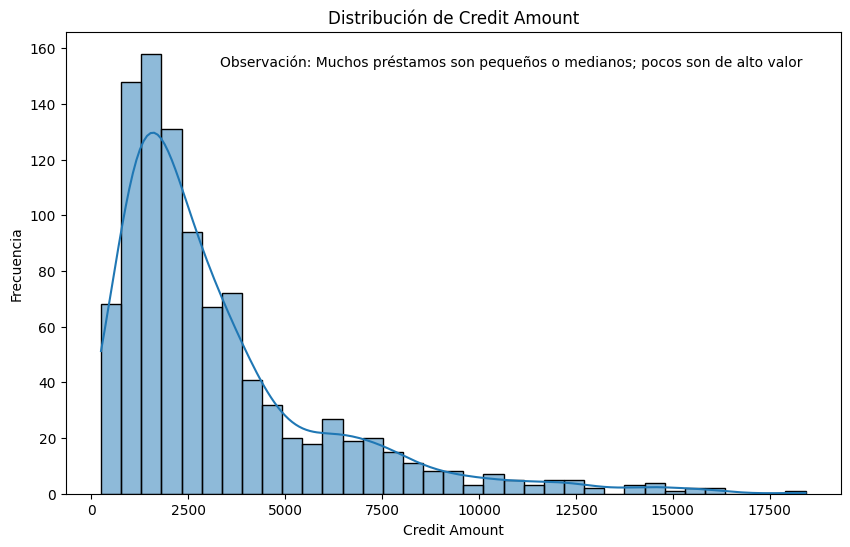

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['credit_amount'], kde=True)
plt.title('Distribución de Credit Amount')
plt.xlabel('Credit Amount')
plt.ylabel('Frecuencia')
plt.text(0.95, 0.95, 'Observación: Muchos préstamos son pequeños o medianos; pocos son de alto valor',
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
plt.show()

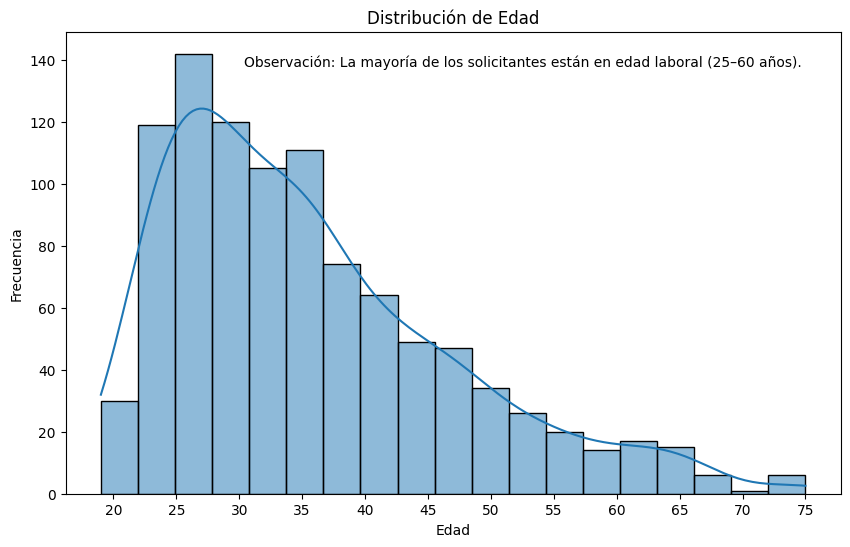

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.xticks(np.linspace(20, 75, 12))
plt.text(0.95, 0.95, 'Observación: La mayoría de los solicitantes están en edad laboral (25–60 años).',
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
plt.show()

In [9]:
foreign_count = df['foreign_worker'].isin(['A202']).sum()
print('Cantidad de extranjeros (A202): ', foreign_count)
print('''Observación: hay muchos más casos "A201" que "A202".
Notas:
 - En la documentación dice que "A201" representa trabajadores extranjeros (no suena lógico)
 - Da la sensación de que la variable está invertida, por lo que vamos a asumir que es asi
 ''')

Cantidad de extranjeros (A202):  37
Observación: hay muchos más casos "A201" que "A202".
Notas:
 - En la documentación dice que "A201" representa trabajadores extranjeros (no suena lógico)
 - Da la sensación de que la variable está invertida, por lo que vamos a asumir que es asi
 


### Posibles Sesgos:

- Histórico: los datos fueron recolectados en un contexto en el que era más común que un préstamo lo pidiera un hombre, por lo que el modelo puede aprender y perpetuar patrones discriminatorios del pasado, reflejando desigualdades estructurales en el acceso al crédito de la época.

- De Representación: hay varias categorías que están subrepresentadas en el dataset, como la cantidad de mujeres, de extranjeros, y de adultos mayores; esto puede hacer que el modelo aprenda patrones poco fiables o erróneos para grupos minoritarios.

- De Aprendizaje: es posible que el modelo priorice a la clase "good credit" dado que es mayoritaria, en cuyo caso se podría amplificar la desigualdad entre clases presente en los datos.

## 2. Desarrollo de un modelo de baseline

Un Falso Negativo en este contexto implica que se le otorgó un préstamo a alguien que no pagó. Por otro lado, los Falsos Positivos representan el caso en el que no se le otorga un préstamo a un cliente que pagaría.

Si nos ponemos en el lugar del banco, que busca maximizar la cantidad de personas que efectivamente van a pagar su préstamo, **los Falsos Negativos son peores**.

Basándonos en la documentación disponible para el conjunto de datos, vimos que se recomienda usar una matriz de costo para penalizar los Falsos Negativos. Por ello, implementamos una función de costo, que utilizaremos como métrica complementaria de evaluación para analizar el impacto económico teórico de las predicciones de cada modelo.

La matriz de costo sugerida para el caso es la siguiente:

\begin{bmatrix}
0 & 1 \\
5 & 0
\end{bmatrix}


In [10]:
# Separar variable objetivo
X = df.drop(['target', 'personal_status_sex'], axis=1) # Drop personal_status_sex
y = df['target']

# Identificar features categóricas y numéricas
# Ensure 'gender' is in categorical features and 'personal_status_sex' is excluded
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Crear transformador para one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

# Mapear: 1 -> 0 (bueno), 2 -> 1 (malo)
y_mapped = y.map({1: 0, 2: 1})

# Función de costo personalizada
def cost_scorer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        cost = fp * 1 + fn * 5
        return -cost
    else:
        return 0

cost_scoring = make_scorer(cost_scorer, greater_is_better=False)

# Pipeline con regresión logística
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=10_000))])

# Split train/test
X_train, X_test, y_train_mapped, y_test_mapped = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

# Entrenamiento y predicciones
pipeline.fit(X_train, y_train_mapped)
y_pred_mapped = pipeline.predict(X_test)

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test_mapped, y_pred_mapped))

# Evaluar costo
cost = cost_scoring(pipeline, X_test, y_test_mapped)
print(f"Costo Total: {cost}")

# Evaluación de métricas estándar
print("\nReporte de Clasificación:")
print(classification_report(y_test_mapped, y_pred_mapped))



Matriz de Confusión:
[[126  15]
 [ 24  35]]
Costo Total: 135

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       141
           1       0.70      0.59      0.64        59

    accuracy                           0.81       200
   macro avg       0.77      0.74      0.75       200
weighted avg       0.80      0.81      0.80       200



### Interpretación de los resultados:

**Matriz de Confusión:**
- Se acierta en la mayoría de los casos.

- Hay más Falsos Negativos que Falsos Positivos: esto resulta problemático desde el punto de vista del costo, ya que estos errores son los más penalizados.

    Con una cuenta rápida se puede ver que la mayor parte del costo total del modelo viene de los Falsos Negativos:

    `total cost = fp * 1 + fn * 5 = 15 + 120 = 135`,

    donde `fp = Falso Positivo`, y `fn = Falso Negativo`

**Accuracy global:**

- Se acierta en un 81% de los casos,

- pero como el dataset está desbalanceado 70/30, este resultado puede ser engañoso, ya que un clasificador trivial que únicamente predice la clase mayoritaria tendría un accuracy del 70%.

**Análisis por clase:**

*Clase 0 = Good Credit:*

- `precisión = 0.84`: Cuando el modelo predice que alguien es “buen cliente”, acierta el 84% de las veces.

- `recall = 0.89`: El modelo detecta correctamente al 89% de los buenos clientes reales.

- `f1-score = 0.87`: Buen compromiso entre precisión y exhaustividad en el grupo.

*Clase 1: Bad Credit:*

- `precisión = 0.70`: Sólo el 70% de los rechazados son “malos pagadores” realmente

- `recall = 0.59`: Se están detectando apenas más de la mitad de los clientes realmente riesgosos; es particularmente crítico porque se definió de antemano que los Falsos Negativos son más costosos.

- `f1-score = 0.64`: Performance deficiente arrastrada por el bajo recall.

---

## 3. Evaluación de Fairness

###Interpretación de los criterios de Group Fairness

- **Statistical parity**: Compara la tasa de predicciones positivas (en este caso, de “mal cliente”) entre grupos sensibles. En este caso se cumple statistical parity si hombres y mujeres reciben el mismo porcentaje de predicciones de mal cliente.


- **Equalized odds**: Exige igualdad tanto en TPR (tasa de verdaderos positivos) como en FPR (tasa de falsos positivos) entre los grupos. En este caso se cumple si para ambos géneros, el modelo detecta correctamente a los malos clientes con la misma frecuencia (TPR) y la proporción de buenos clientes marcados como malos es igual (FPR).


- **Equal opprtunity**: Compara la tasa de verdaderos positivos (TPR) entre grupos. Es decir que para ambos géneros compara la proporción de los malos clientes que el modelo identifica correctamente.


- **Predictive parity**: Compara la precisión (PPV) de las predicciones positivas entre grupos, es decir, de todos los que el modelo predijo como malos clientes, cuántos realmente lo son. Si la precisión es igual para hombres y mujeres, significa que una predicción de mal cliente tiene el mismo nivel de confiabilidad sin importar el género.

Inicialmente, elegimos comparar los Base Rates para los géneros, que en este caso representan la proporción de "malos pagadores".

Base rate of 'bad credit' applications by gender:
gender
female    0.648387
male      0.723188
Name: 1, dtype: float64


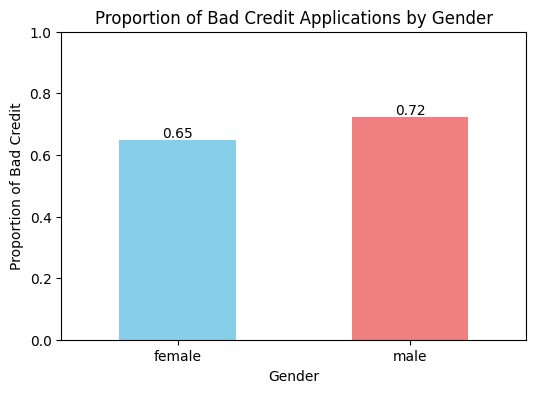

In [27]:
# Compare base rates (proportion of 'bad credit' applications) for each gender

# Calculate the base rate for each gender
base_rates = df.groupby('gender')['target'].value_counts(normalize=True).unstack()

# The target variable is mapped: 0 for good credit, 1 for bad credit
# We are interested in the proportion of 'bad credit' (target = 1)
bad_credit_base_rates = base_rates[1]

print("Base rate of 'bad credit' applications by gender:")
print(bad_credit_base_rates)

# Optional: Visualize the base rates
plt.figure(figsize=(6, 4))
ax = bad_credit_base_rates.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Proportion of Bad Credit Applications by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion of Bad Credit')
plt.xticks(rotation=0)
plt.ylim(0, 1)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

- Existe una diferencia inherente en el riesgo crediticio REAL entre géneros en los datos de entrenamiento.

- Hombres: 72.3% de mal crédito vs Mujeres: 64.8% → Diferencia de ~7.5 puntos porcentuales.

- Esto significa que, incluso un modelo perfecto, produciría diferencias en Statistical Parity.


Para evaluar si nuestros modelos son _fair_ o no según los criterios explicados, tomamos el módulo de la diferencia de las métricas para hombres vs. mujeres, y usamos un umbral fijo en `UMBRAL = 0.1`. Esto sería una diferencia entre un grupo y el otro del $10\text{%}$,  lo cuál permite variaciones que pueden reflejar diferencias reales en el riesgo subyacente.

In [11]:
# Use the correct sensitive feature variable from the split
sensitive_feature_test = X_test["gender"]


metrics = {
    "Statistical Parity": selection_rate,
    "Equal Opportunity (TPR)": true_positive_rate,
    "FPR": false_positive_rate,
    "Predictive Parity (Precision)": precision_score
}

mf = MetricFrame(
    metrics=metrics,
    y_true=y_test_mapped,
    y_pred=y_pred_mapped,
    sensitive_features=sensitive_feature_test # Use the correct variable
)

print("Métricas de Fairness: ")
print(mf.by_group)

# Calcular Equalized Odds Difference (TPR y FPR)
equalized_odds_diff = max(
    abs(mf.difference(method='between_groups')['Equal Opportunity (TPR)']),
    abs(mf.difference(method='between_groups')['FPR'])
)

# Interpretación rápida
print("\nDiferencia entre géneros")
print(f"- Statistical Parity Difference: {mf.difference(method='between_groups')['Statistical Parity']:.3f}")
print(f"- Equal Opportunity Difference (TPR): {mf.difference(method='between_groups')['Equal Opportunity (TPR)']:.3f}")
print(f"- Predictive Parity Difference (Precision): {mf.difference(method='between_groups')['Predictive Parity (Precision)']:.3f}")
print(f"- Equalized Odds Difference: {equalized_odds_diff:.3f}")

# Comparar contra el umbral definido
UMBRAL = 0.1
stat_parity_fair = [mf.difference(method='between_groups')['Statistical Parity'] <= UMBRAL]
equal_opp_fair = [mf.difference(method='between_groups')['Equal Opportunity (TPR)'] <= UMBRAL]
pred_parity_fair = [mf.difference(method='between_groups')['Predictive Parity (Precision)'] <= UMBRAL]
equalized_odds_fair = [equalized_odds_diff <= UMBRAL]

print("\n¿Se cumplen los criterios de fairness?:")
print(f"- Statistical Parity : {stat_parity_fair[0]}")
print(f"- Equal Opportunity (TPR): {equal_opp_fair[0]}")
print(f"- Predictive Parity (Precision): {pred_parity_fair[0]}")
print(f"- Equalized Odds : {equalized_odds_fair[0]}")

Métricas de Fairness: 
        Statistical Parity  Equal Opportunity (TPR)       FPR  \
gender                                                          
female            0.232143                 0.588235  0.076923   
male              0.256944                 0.595238  0.117647   

        Predictive Parity (Precision)  
gender                                 
female                       0.769231  
male                         0.675676  

Diferencia entre géneros
- Statistical Parity Difference: 0.025
- Equal Opportunity Difference (TPR): 0.007
- Predictive Parity Difference (Precision): 0.094
- Equalized Odds Difference: 0.041

¿Se cumplen los criterios de fairness?:
- Statistical Parity : True
- Equal Opportunity (TPR): True
- Predictive Parity (Precision): True
- Equalized Odds : True


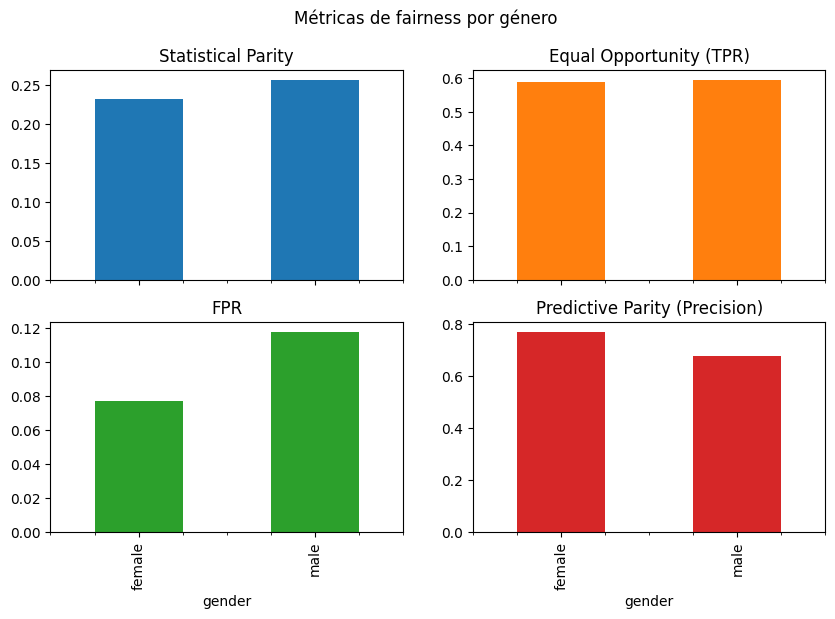

In [12]:
mf.by_group.plot.bar(subplots=True, layout=(2,2), figsize=(10,6),
                     title="Métricas de fairness por género", legend=False)
plt.show()

Teniendo en cuenta el umbral definido previamente, se puede concluir que este modelo **es fair**, ya que ninguna de las diferencias es mayor a `0.1`.

Sin embargo, viendo el gráfico se puede identificar que:
* el `FPR` es superior para el género masculino,
* tanto la `precisión` como el `TPR` son levemente mejores para el género femenino.

Por ende, podría decirse que el modelo funciona un poco peor en personas del género masculino.

Desde el punto de vista del banco, para identificar un sesgo de género, el criterio más relevante es **Equal opportunity**. El hecho de que se cumpla este criterio significa que el modelo no favorece ni perjudica ningún género a la hora de identificar a los malos pagadores. Además, el TPR tiene en cuenta a los FN, lo cual ya mencionamos que es relevante para el banco.

Por otro lado, el criterio **Predictive parity** es relevante si se busca que el desempeño del modelo sea bueno y confiable para ambos géneros por igual. Una diferencia de precisión entre los grupos significa que el modelo tiene un desempeño desigual y podría estar favoreciendo a un género en términos de exactitud predictiva.

## 4. Mitigación de sesgos

Como se pudo ver en el análisis exploratorio, uno de los factores negativos del dataset es su desbalance. Para corregir eso, puede ser útil emplear el método reweighing en el pre-procesamiento.

Por otro lado, para balancear el FPR es pertinente aplicar el método de correción del clasificador: Equalized Odds en el post-procesamiento.

In [13]:
# Use the 'gender' column directly from the original dataframe
sensitive_feature = df['gender']

# Split the sensitive attribute in train and test - this split should align with the X, y split
# Re-splitting X, y, and sensitive_feature together to ensure consistency
X_train, X_test, y_train_mapped, y_test_mapped, s_train, s_test = train_test_split(
    X, y_mapped, sensitive_feature, test_size=0.2, random_state=42
)

In [14]:
# Mitigación con Reweighing
mitigator = Reweighing()
model = LogisticRegression(max_iter=10_000)
pipeline = HPipeline(steps=[
    ('preprocessor', preprocessor),
    ('bm_preprocessing', mitigator),
    ('classifier', model)
])

# Use the correct sensitive feature variables from the split
pipeline.fit(X_train, y_train_mapped,
             bm__group_a=(s_train == 'male'),
             bm__group_b=(s_train == 'female'))

y_pred_rw = pipeline.predict(
    X_test,
    bm__group_a=(s_test == 'male'),
    bm__group_b=(s_test == 'female')
)

###Equalized Odds

In [15]:
# Post-procesamiento with Equalized Odds

# Create post-processing mitigator
eo_mitigator = EqualizedOdds()

# Fit the mitigator
# Use the correct sensitive feature variables from the split
eo_mitigator.fit(
    y=y_test_mapped,
    y_pred=y_pred_rw,
    group_a=(s_test == 'male'),
    group_b=(s_test == 'female')
)


# Apply post-processing mitigation
# Use the correct sensitive feature variables from the split
y_pred_eo = eo_mitigator.transform(
    y_pred=y_pred_rw,
    group_a=(s_test == 'male'),
    group_b=(s_test == 'female')
)

### Evaluación

In [21]:
# Evaluación de métricas estándar
print('='*60)
print("Reporte de Clasificación antes de aplicar Equalize Odds (solo Reweighing):")
print('='*60)
print(classification_report(y_test_mapped, y_pred_rw))

print("\nMatriz de Confusión antes de aplicar Equalize Odds (solo Reweighing):")
print(confusion_matrix(y_test_mapped, y_pred_rw))

# Evaluar costo
cost_rw = cost_scorer(y_test_mapped, y_pred_rw)
print(f"Costo Total (solo Reweighing): {-cost_rw}")

y_pred_final = y_pred_eo['y_pred']

print('\n', '='*60)
print("Reporte de Clasificación final (Reweighing y Equalize Odds):")
print('='*60)
print(classification_report(y_test_mapped, y_pred_final))

print("\nMatriz de Confusión final (Reweighing y Equalize Odds):")
print(confusion_matrix(y_test_mapped, y_pred_final))

# Evaluar costo
cost_final = cost_scorer(y_test_mapped, y_pred_final)
print(f"Costo Total (Reweighing y Equalize Odds): {-cost_final}")

Reporte de Clasificación antes de aplicar Equalize Odds (solo Reweighing):
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       141
           1       0.65      0.56      0.60        59

    accuracy                           0.78       200
   macro avg       0.74      0.72      0.72       200
weighted avg       0.77      0.78      0.78       200


Matriz de Confusión antes de aplicar Equalize Odds (solo Reweighing):
[[123  18]
 [ 26  33]]
Costo Total (solo Reweighing): 148

Reporte de Clasificación final (Reweighing y Equalize Odds):
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       141
           1       0.62      0.49      0.55        59

    accuracy                           0.76       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.75      0.76      0.75       200


Matriz de Confusión final (Reweighing y Equalize Odds):
[[123  18]
 [ 30  29]]


### Interpretación

Si comparamos con las métricas del primer modelo, vemos que en la mayoría de métricas decae levemente la performance. Sumados a esto, después de aplicar Equalized Odds empeora un poco más.

Por ende podemos decir que los métodos de mitigación de sesgos repercuten negativamente en la performance de las predicciones del modelo.

###Evaluación de Fairness


 Fairness Metrics (Reweighting before Equalize Odds):
        Statistical Parity  Equal Opportunity (TPR)       FPR  \
gender                                                          
female            0.196429                 0.470588  0.076923   
male              0.277778                 0.595238  0.147059   

        Predictive Parity (Precision)  
gender                                 
female                       0.727273  
male                         0.625000  

Difference between genders:
- Statistical Parity Difference: 0.081
- Equal Opportunity Difference (TPR): 0.125
- Predictive Parity Difference (Precision): 0.102
- Equalized Odds Difference: 0.125


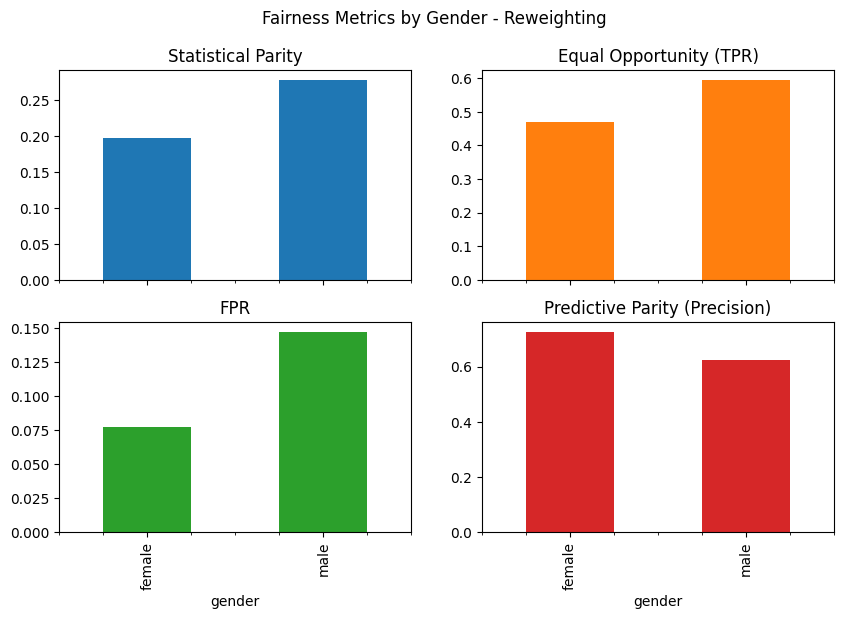

In [22]:
# Evaluación (solo reweighing) with fairness metrics
metrics = {
    "Statistical Parity": selection_rate,
    "Equal Opportunity (TPR)": true_positive_rate,
    "FPR": false_positive_rate,
    "Predictive Parity (Precision)": precision_score
}

# Use the correct sensitive feature variable from the split
mf_rw = MetricFrame(
    metrics=metrics,
    y_true=y_test_mapped,
    y_pred=y_pred_rw,
    sensitive_features=s_test
)

print("\n Fairness Metrics (Reweighting before Equalize Odds):")
print(mf_rw.by_group)

equalized_odds_diff_rw= max(
    abs(mf_rw.difference(method='between_groups')['Equal Opportunity (TPR)']),
    abs(mf_rw.difference(method='between_groups')['FPR'])
)

print("\nDifference between genders:")
print(f"- Statistical Parity Difference: {mf_rw.difference(method='between_groups')['Statistical Parity']:.3f}")
print(f"- Equal Opportunity Difference (TPR): {mf_rw.difference(method='between_groups')['Equal Opportunity (TPR)']:.3f}")
print(f"- Predictive Parity Difference (Precision): {mf_rw.difference(method='between_groups')['Predictive Parity (Precision)']:.3f}")
print(f"- Equalized Odds Difference: {equalized_odds_diff_rw:.3f}")

mf_rw.by_group.plot.bar(subplots=True, layout=(2,2), figsize=(10,6),
                        title="Fairness Metrics by Gender - Reweighting",
                        legend=False)
plt.show()


 Fairness Metrics (Reweighting and Equalized Odds):
        Statistical Parity  Equal Opportunity (TPR)       FPR  \
gender                                                          
female            0.232143                 0.470588  0.128205   
male              0.236111                 0.500000  0.127451   

        Predictive Parity (Precision)  
gender                                 
female                       0.615385  
male                         0.617647  

Difference between genders:
- Statistical Parity Difference: 0.004
- Equal Opportunity Difference (TPR): 0.029
- Predictive Parity Difference (Precision): 0.002
- Equalized Odds Difference: 0.029


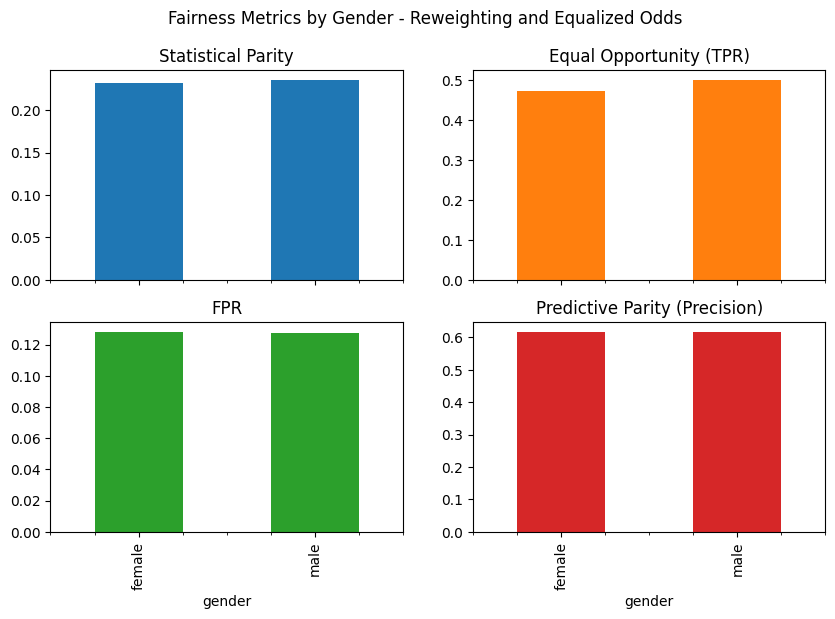

In [23]:
# Evaluación with fairness metrics
metrics = {
    "Statistical Parity": selection_rate,
    "Equal Opportunity (TPR)": true_positive_rate,
    "FPR": false_positive_rate,
    "Predictive Parity (Precision)": precision_score
}

# Use the correct sensitive feature variable from the split
mf_final = MetricFrame(
    metrics=metrics,
    y_true=y_test_mapped,
    y_pred=y_pred_final,
    sensitive_features=s_test
)

print("\n Fairness Metrics (Reweighting and Equalized Odds):")
print(mf_final.by_group)

equalized_odds_diff_final= max(
    abs(mf_final.difference(method='between_groups')['Equal Opportunity (TPR)']),
    abs(mf_final.difference(method='between_groups')['FPR'])
)

print("\nDifference between genders:")
print(f"- Statistical Parity Difference: {mf_final.difference(method='between_groups')['Statistical Parity']:.3f}")
print(f"- Equal Opportunity Difference (TPR): {mf_final.difference(method='between_groups')['Equal Opportunity (TPR)']:.3f}")
print(f"- Predictive Parity Difference (Precision): {mf_final.difference(method='between_groups')['Predictive Parity (Precision)']:.3f}")
print(f"- Equalized Odds Difference: {equalized_odds_diff_final:.3f}")

mf_final.by_group.plot.bar(subplots=True, layout=(2,2), figsize=(10,6),
                        title="Fairness Metrics by Gender - Reweighting and Equalized Odds",
                        legend=False)
plt.show()

###Interpretación
En términos de Fairness el modelo mejoró. Todas las diferencias se redujeron en relación al modelo anterior, salvo la del TPR, la cual aumentó. Sin embargo, sigue lejos del umbral de 0.1.

Es decir que después de haber aplicado Reweighing y la correción de Equalize Odds, el modelo es fair según estos cuatro criterios.

---

# Conclusiones

Algunas conclusiones clave del análisis realizado en este notebook:

*   El conjunto de datos "German Credit Data" muestra signos iniciales de desbalance de clases (más casos de "buen crédito" que de "mal crédito") y posible sesgo de representación con respecto al género (más solicitantes masculinos que femeninos).

*   El modelo de regresión logística _baseline_,  logra una precisión general razonable.

*   La evaluación inicial de equidad del modelo de referencia, utilizando el umbral definido, indicó que era justo según los criterios seleccionados (Statistical Parity, Equalized Odds, Equal Opportunity y Predictive Parity), aunque se observaron ligeras disparidades en la Tasa de Falsos Positivos (FPR) y la Precisión entre géneros.

*   La aplicación de la técnica de pre-procesamiento Reweighing tuvo, por si sola, un impacto inesperado en las metricas de _fairness_ a la vez que el empeoramiento en las predicciones.

*   La aplicación de la técnica de post-procesamiento Probabilidades Ecualizadas (Equalized Odds) después de Reweighing mejoró aún más las métricas de equidad, reduciendo las diferencias entre grupos muy por debajo del umbral definido para todos los criterios evaluados.

*   Sin embargo, la combinación de Reweighing y Probabilidades Ecualizadas resultó en una disminución adicional en el rendimiento general del modelo (precisión, recall, F1-score) y un costo total mayor en comparación con el modelo de referencia y el modelo con solo Reweighing.

*   Este análisis demuestra la existencia de un compromiso (trade-off) entre el rendimiento del modelo y la equidad, donde mejorar la equidad a veces puede llevar a una reducción en las métricas de rendimiento tradicionales y un aumento en los costos definidos por el negocio (como los de la matriz de costos).

*   Podría ser necesaria una mayor investigación y potencialmente diferentes estrategias de mitigación para encontrar un mejor equilibrio entre el logro de los objetivos de equidad y el mantenimiento de niveles aceptables de rendimiento del modelo y rentabilidad.